In [2]:
#Pre setup
# Download pre-trained FaceNet model that will be used for image embedding process
import os

if not os.path.exists('facenet_keras.h5'):
    ! wget https://github.com/D2KLab/Face-Celebrity-Recognition/raw/master/model/facenet_keras.h5
try:
    import mtcnn
except ModuleNotFoundError:
    ! pip install mtcnn

try:
    import split_folders
except ModuleNotFoundError:
    ! pip install split-folders

Using TensorFlow backend.


In [3]:
#Import all the libs needed
import mtcnn
import numpy as np
import os
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model

In [4]:
# Preparing kaggle environment to download the dataset. For a reference of how to get kaggle.json, please see https://www.kaggle.com/general/74235
! pip install -q kaggle
from google.colab import files
files.upload() # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ibamibrahim","key":"xxxxxxxxxxx"}'}

In [7]:
# Download and split the dataset into train/val dataset
# The data set source https://www.kaggle.com/hereisburak/pins-face-recognition

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d hereisburak/pins-face-recognition
! unzip -q pins-face-recognition.zip

import split_folders
training_examples = 20
validation_examples = 7
collection_dir = 'pins_dataset'

split_folders.fixed(input='105_classes_pins_dataset', output=collection_dir, fixed=(training_examples, validation_examples))

mkdir: cannot create directory ‘/root/.kaggle’: File exists
pins-face-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)
replace 105_classes_pins_dataset/pins_Adriana Lima/Adriana Lima0_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Copying files: 17534 files [00:04, 3522.05 files/s]


## Face Detection
Purpose for this cell is to get a face only dataset from the given dataset, to be able to be used in face embedding process. The faces extracted will save all the detected face to faces-only-dataset.npz format

processing pins_dataset/val/pins_Tom Holland/ (1 out of 105)...
>loaded 20 examples for class pins_Tom Holland in 23 seconds.
processing pins_dataset/val/pins_Sophie Turner/ (2 out of 105)...
>loaded 20 examples for class pins_Sophie Turner in 24 seconds.
processing pins_dataset/val/pins_Katharine Mcphee/ (3 out of 105)...
>loaded 20 examples for class pins_Katharine Mcphee in 22 seconds.
processing pins_dataset/val/pins_Shakira Isabel Mebarak/ (4 out of 105)...
>loaded 20 examples for class pins_Shakira Isabel Mebarak in 24 seconds.
processing pins_dataset/val/pins_Jason Momoa/ (5 out of 105)...
>loaded 20 examples for class pins_Jason Momoa in 23 seconds.
processing pins_dataset/val/pins_elizabeth olsen/ (6 out of 105)...
>loaded 20 examples for class pins_elizabeth olsen in 24 seconds.
processing pins_dataset/val/pins_Bobby Morley/ (7 out of 105)...
>loaded 20 examples for class pins_Bobby Morley in 25 seconds.
processing pins_dataset/val/pins_Maria Pedraza/ (8 out of 105)...
>loade

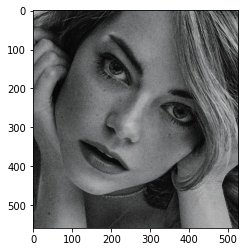

>loaded 19 examples for class pins_Emma Stone in 27 seconds.
processing pins_dataset/val/pins_Brenton Thwaites/ (24 out of 105)...
>loaded 20 examples for class pins_Brenton Thwaites in 29 seconds.
processing pins_dataset/val/pins_Rami Malek/ (25 out of 105)...
>loaded 20 examples for class pins_Rami Malek in 29 seconds.
processing pins_dataset/val/pins_Tom Cruise/ (26 out of 105)...
>loaded 20 examples for class pins_Tom Cruise in 28 seconds.
processing pins_dataset/val/pins_Tuppence Middleton/ (27 out of 105)...
>loaded 20 examples for class pins_Tuppence Middleton in 29 seconds.
processing pins_dataset/val/pins_barack obama/ (28 out of 105)...
>loaded 20 examples for class pins_barack obama in 30 seconds.
processing pins_dataset/val/pins_camila mendes/ (29 out of 105)...
>loaded 20 examples for class pins_camila mendes in 28 seconds.
processing pins_dataset/val/pins_Keanu Reeves/ (30 out of 105)...
>loaded 20 examples for class pins_Keanu Reeves in 31 seconds.
processing pins_datase

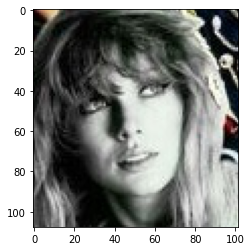

pins_dataset/val/pins_Taylor Swift/Taylor Swift20_4611.jpg face cannot be detected


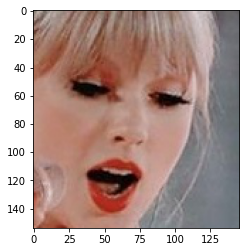

>loaded 18 examples for class pins_Taylor Swift in 34 seconds.
processing pins_dataset/val/pins_Anne Hathaway/ (42 out of 105)...
>loaded 20 examples for class pins_Anne Hathaway in 35 seconds.
processing pins_dataset/val/pins_Irina Shayk/ (43 out of 105)...
>loaded 20 examples for class pins_Irina Shayk in 32 seconds.
processing pins_dataset/val/pins_kiernen shipka/ (44 out of 105)...
>loaded 20 examples for class pins_kiernen shipka in 35 seconds.
processing pins_dataset/val/pins_Nadia Hilker/ (45 out of 105)...
>loaded 20 examples for class pins_Nadia Hilker in 35 seconds.
processing pins_dataset/val/pins_Megan Fox/ (46 out of 105)...
pins_dataset/val/pins_Megan Fox/Megan Fox58_3536.jpg face cannot be detected


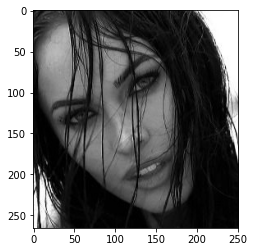

>loaded 19 examples for class pins_Megan Fox in 35 seconds.
processing pins_dataset/val/pins_Sarah Wayne Callies/ (47 out of 105)...
>loaded 20 examples for class pins_Sarah Wayne Callies in 36 seconds.
processing pins_dataset/val/pins_Henry Cavil/ (48 out of 105)...
>loaded 20 examples for class pins_Henry Cavil in 37 seconds.
processing pins_dataset/val/pins_Dwayne Johnson/ (49 out of 105)...
>loaded 20 examples for class pins_Dwayne Johnson in 37 seconds.
processing pins_dataset/val/pins_elon musk/ (50 out of 105)...
>loaded 20 examples for class pins_elon musk in 35 seconds.
processing pins_dataset/val/pins_margot robbie/ (51 out of 105)...
>loaded 20 examples for class pins_margot robbie in 39 seconds.
processing pins_dataset/val/pins_Rihanna/ (52 out of 105)...
>loaded 20 examples for class pins_Rihanna in 38 seconds.
processing pins_dataset/val/pins_Stephen Amell/ (53 out of 105)...
>loaded 20 examples for class pins_Stephen Amell in 38 seconds.
processing pins_dataset/val/pins_

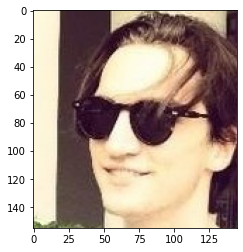

>loaded 19 examples for class pins_Richard Harmon in 35 seconds.
processing pins_dataset/val/pins_Christian Bale/ (55 out of 105)...
>loaded 20 examples for class pins_Christian Bale in 39 seconds.
processing pins_dataset/val/pins_Elizabeth Lail/ (56 out of 105)...
pins_dataset/val/pins_Elizabeth Lail/Elizabeth Lail194_1117.jpg face cannot be detected


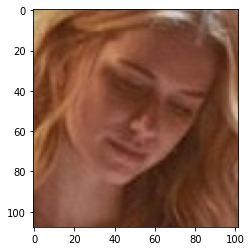

>loaded 19 examples for class pins_Elizabeth Lail in 39 seconds.
processing pins_dataset/val/pins_Katherine Langford/ (57 out of 105)...
>loaded 20 examples for class pins_Katherine Langford in 36 seconds.
processing pins_dataset/val/pins_Josh Radnor/ (58 out of 105)...
>loaded 20 examples for class pins_Josh Radnor in 39 seconds.
processing pins_dataset/val/pins_Jimmy Fallon/ (59 out of 105)...
>loaded 20 examples for class pins_Jimmy Fallon in 39 seconds.
processing pins_dataset/val/pins_Robert Downey Jr/ (60 out of 105)...
>loaded 20 examples for class pins_Robert Downey Jr in 40 seconds.
processing pins_dataset/val/pins_Brie Larson/ (61 out of 105)...
>loaded 20 examples for class pins_Brie Larson in 37 seconds.
processing pins_dataset/val/pins_Morena Baccarin/ (62 out of 105)...
>loaded 20 examples for class pins_Morena Baccarin in 40 seconds.
processing pins_dataset/val/pins_Chris Evans/ (63 out of 105)...
>loaded 20 examples for class pins_Chris Evans in 41 seconds.
processing p

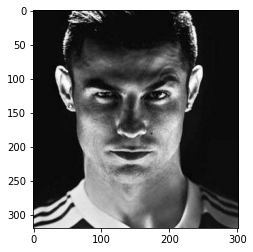

>loaded 19 examples for class pins_Cristiano Ronaldo in 40 seconds.
processing pins_dataset/val/pins_Zoe Saldana/ (74 out of 105)...
>loaded 20 examples for class pins_Zoe Saldana in 44 seconds.
processing pins_dataset/val/pins_Emilia Clarke/ (75 out of 105)...
>loaded 20 examples for class pins_Emilia Clarke in 45 seconds.
processing pins_dataset/val/pins_Zac Efron/ (76 out of 105)...
>loaded 20 examples for class pins_Zac Efron in 44 seconds.
processing pins_dataset/val/pins_Lili Reinhart/ (77 out of 105)...
pins_dataset/val/pins_Lili Reinhart/Lili Reinhart14_2738.jpg face cannot be detected


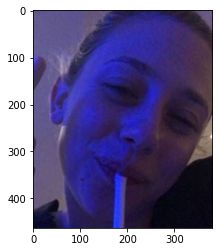

>loaded 19 examples for class pins_Lili Reinhart in 42 seconds.
processing pins_dataset/val/pins_Madelaine Petsch/ (78 out of 105)...
>loaded 20 examples for class pins_Madelaine Petsch in 45 seconds.
processing pins_dataset/val/pins_Mark Ruffalo/ (79 out of 105)...
>loaded 20 examples for class pins_Mark Ruffalo in 45 seconds.
processing pins_dataset/val/pins_gal gadot/ (80 out of 105)...
>loaded 20 examples for class pins_gal gadot in 46 seconds.
processing pins_dataset/val/pins_Krysten Ritter/ (81 out of 105)...
>loaded 20 examples for class pins_Krysten Ritter in 42 seconds.
processing pins_dataset/val/pins_melissa fumero/ (82 out of 105)...
>loaded 20 examples for class pins_melissa fumero in 45 seconds.
processing pins_dataset/val/pins_Chris Pratt/ (83 out of 105)...
>loaded 20 examples for class pins_Chris Pratt in 46 seconds.
processing pins_dataset/val/pins_Marie Avgeropoulos/ (84 out of 105)...
>loaded 20 examples for class pins_Marie Avgeropoulos in 47 seconds.
processing pi

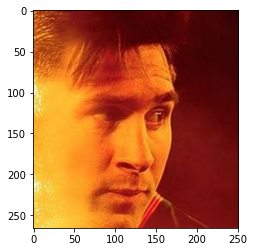

>loaded 19 examples for class pins_Lionel Messi in 46 seconds.
processing pins_dataset/val/pins_Jessica Barden/ (90 out of 105)...
>loaded 20 examples for class pins_Jessica Barden in 50 seconds.
processing pins_dataset/val/pins_Alvaro Morte/ (91 out of 105)...
>loaded 20 examples for class pins_Alvaro Morte in 50 seconds.
processing pins_dataset/val/pins_amber heard/ (92 out of 105)...
>loaded 20 examples for class pins_amber heard in 49 seconds.
processing pins_dataset/val/pins_Avril Lavigne/ (93 out of 105)...
>loaded 20 examples for class pins_Avril Lavigne in 45 seconds.
processing pins_dataset/val/pins_Jennifer Lawrence/ (94 out of 105)...
>loaded 20 examples for class pins_Jennifer Lawrence in 50 seconds.
processing pins_dataset/val/pins_Jake Mcdorman/ (95 out of 105)...
>loaded 20 examples for class pins_Jake Mcdorman in 50 seconds.
processing pins_dataset/val/pins_Pedro Alonso/ (96 out of 105)...
>loaded 20 examples for class pins_Pedro Alonso in 51 seconds.
processing pins_da

In [11]:
import time

def extract_face(filename, required_size=(160,160)):
    detector = MTCNN()
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    faces = detector.detect_faces(pixels)

    face_array = None
    if len(faces) > 0:
      initialX, initialY, initialWidth, initialHeight = faces[0]['box']
      used_index = 0
      highestWidth = initialX
      highestHeight = initialY
      index = 0
      for face in faces:
      #With Assumption that we're going to close up the targetted person
          x, y, width, height = face['box']
          if width > highestWidth or height > highestHeight :
              used_index = index
              break

          index = index + 1
          
      x1, y1, width, height = faces[used_index]['box']    
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
      face_boundary = pixels[y1:y2, x1:x2]
      face_image = Image.fromarray(face_boundary)
      face_image = face_image.resize(required_size)
      face_array = asarray(face_image)
      # print(used_index)
      return face_array
    else:
      print(f'{filename} face cannot be detected')
      plt.imshow(image)
      plt.show()
    return face_array

def load_faces(directory):
    faces = []
    for filename in os.listdir(directory):
      path = os.path.join(directory, filename)
      face = extract_face(path)
      if face is not None:
        faces.append(face)
    return faces

def load_dataset(directory):
    x, y = [], []
    counter = 1
    start_time = time.time()
    for subdir in os.listdir(directory):
      mid_time = time.time()
      path = os.path.join(directory, subdir + '/') # e.g: train/ben_afflect/
      print(f'processing {path} ({counter} out of {len(os.listdir(directory))})...')
      faces = load_faces(path)
      labels = [subdir for i in range(len(faces))] # assign label to each face
      x.extend(faces)
      y.extend(labels)
      print('>loaded %d examples for class %s in %d seconds.' % (len(faces), subdir, time.time() - mid_time))
      counter += 1
    end_time = time.time()
    print(f'Finish processing {directory} for {end_time - start_time} seconds.')
    return asarray(x), asarray(y)

train_dir = os.path.join(collection_dir, 'val')
train_X, train_y = load_dataset(train_dir)
print(train_X.shape, train_y.shape)
val_dir = os.path.join(collection_dir, 'test')
val_X, val_y = load_dataset(val_dir)
print(val_X.shape, val_y.shape)
np.savez_compressed('faces-only-dataset.npz', train_X, train_y, val_X, val_y)

#Create Embedding for Each Face
From the face generated earlier, we create an embedding of the face using FaceNet

In [12]:
import time

data = np.load('faces-only-dataset.npz')
train_X, train_y = data['arr_0'], data['arr_1']
test_X, test_y = data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (train_X.shape[0], test_X.shape[0]))
print('Loaded: ', train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = load_model('facenet_keras.h5')
print('Loaded Model')

def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis=0)
    y_hat = model.predict(samples) # get the embedding
    return y_hat

start = time.time()
new_train_X = list()
for face_pixels in train_X:
	embedding = get_embedding(model, face_pixels)
	new_train_X.extend(embedding)
 
new_train_X = asarray(new_train_X)
print(new_train_X.shape)

new_test_X = list()
for face_pixels in test_X:
	embedding = get_embedding(model, face_pixels)
	new_test_X.extend(embedding)
new_test_X = asarray(new_test_X)

print(new_test_X.shape)
end = time.time()
print(f'End processing for {end - start} seconds')

np.savez_compressed('faces-embeddings.npz', new_train_X, train_y, new_test_X, test_y)

Dataset: train=2091, test=735
Loaded:  (2091, 160, 160, 3) (2091,) (735, 160, 160, 3) (735,)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(2091, 128)
(735, 128)
End processing for 143.72885251045227 seconds


## Performing Faces Classification

From the embedding, we perform the face classification using SVM model and the embedding as the feature. The target is the face classes (whom the face is)

In [21]:
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

data = np.load('faces-embeddings.npz')
train_X, train_y = data['arr_0'], data['arr_1']
test_X, test_y = data['arr_2'], data['arr_3']

encoder = LabelEncoder()
encoder.fit(train_y)

label_classes = encoder.classes_
train_y_encoded = encoder.transform(train_y)
test_y_encoded = encoder.transform(test_y)

# define the keras model
model_vector_classifier = Sequential()
model_vector_classifier.add(Dense(64, input_dim=128, activation='relu'))
model_vector_classifier.add(Dense(32, activation='relu'))
model_vector_classifier.add(Dense(105, activation='softmax'))
model_vector_classifier.summary()

model_vector_classifier.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_vector_classifier.fit(train_X, train_y_encoded, epochs=15, batch_size=10, verbose=0)

_, score_train = model_vector_classifier.evaluate(train_X, train_y_encoded)
_, score_test = model_vector_classifier.evaluate(test_X, test_y_encoded)


print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26271 (Dense)          (None, 64)                8256      
_________________________________________________________________
dense_26272 (Dense)          (None, 32)                2080      
_________________________________________________________________
dense_26273 (Dense)          (None, 105)               3465      
Total params: 13,801
Trainable params: 13,801
Non-trainable params: 0
_________________________________________________________________
735/735 [==============================] - 0s 58us/step
Accuracy: train=100.000, test=92.925


In [33]:
def top_10_prediction(prob, labels):
    sorted_rank = (-prob).argsort()[:10]
    label_prob = {}
    counter = 0
    for index in sorted_rank:
        class_ = labels[index]
        probability = prob[index]
        label_prob[class_.replace(' ', '_')] = probability*100
        counter += 1

    s = sorted(label_prob.items(), key=lambda x: x[1], reverse=True)[:10]
    for k, v in s:
        print(k.replace('pins_', '').replace('_', ' '), f'{v:.2f}%')

Predicted: pins_Leonardo DiCaprio (89.577)
Expected: pins_Leonardo DiCaprio


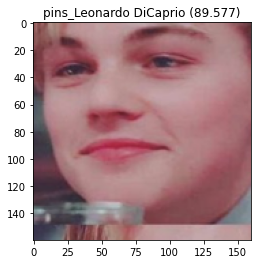

Leonardo DiCaprio 89.58%
Logan Lerman 5.57%
Tom Hardy 3.54%
Tom Holland 1.15%
Johnny Depp 0.09%
Selena Gomez 0.04%
grant gustin 0.01%
Marie Avgeropoulos 0.01%
Lili Reinhart 0.01%
Ben Affleck 0.00%


In [36]:
# test model on a random example from the test dataset
import random
data = np.load('faces-only-dataset.npz')
test_X_faces = data['arr_2']

selection = random.choice([i for i in range(test_X.shape[0])])
random_face_pixels = test_X_faces[selection]
random_face_emb = test_X[selection]
random_face_class = test_y_encoded[selection]
random_face_name = encoder.inverse_transform([random_face_class])
# prediction for the face
samples = np.expand_dims(random_face_emb, axis=0)
yhat_class = model_vector_classifier.predict_classes(samples)
yhat_prob = model_vector_classifier.predict(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
plt.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()
top_10_prediction(yhat_prob[0], encoder.classes_)

## Export the Model

Export the model to be used in other environment

In [37]:
import json
model_vector_classifier.save('vector_classifier.h5')
with open('label_classes.json', 'w') as outfile:
    json.dump(list(encoder.classes_), outfile)

## Using Pretrained Model from Code Above

In [46]:
def setup():
    # Download pre-trained FaceNet model, pre-trained SVM, and photo labels
    import os

    if not os.path.exists('facenet_keras.h5'):
        !wget https://github.com/D2KLab/Face-Celebrity-Recognition/raw/master/model/facenet_keras.h5
    if not os.path.exists('label_classes.json'):      
        !wget https://ibam.imfast.io/label_classes.json
    if not os.path.exists('vector_classifier.h5'):
        !wget https://ibam.imfast.io/vector_classifier.h5

    # install mtcnn
    try:
        import mtcnn
    except ModuleNotFoundError:
        !pip install mtcnn

def get_pre_trained():
    import json
    import numpy as np
    from keras.models import load_model

    face_classes = json.load(open('label_classes.json'))
    model_vector_classifier = load_model('vector_classifier.h5')
    model_facenet = load_model('facenet_keras.h5')
    return model_facenet, model_vector_classifier, face_classes

def extract_face(filename, required_size=(160,160)):
    from mtcnn.mtcnn import MTCNN
    from numpy import asarray
    from PIL import Image
    from matplotlib import pyplot as plt

    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    # detect face
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    # bounding box
    x1, y1, width, height = results[0]['box'] # assuming the photo only contains one face
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)    
    plt.imshow(face)
    plt.show()
    
    return face_array

def get_embedding(model, face_pixels):
    import numpy as np

    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis=0)
    y_hat = model.predict(samples) # get the embedding
    return y_hat

def predict_face(model_facenet, model_vector_classifier, face_classes):
    from google.colab import files

    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    face_pixels = extract_face(file_name)
    embedding = get_embedding(model_facenet, face_pixels)

    predicted_class = model_vector_classifier.predict_classes(embedding)
    probability = model_vector_classifier.predict(embedding)[0]
    predicted_name = face_classes[predicted_class[0]]
    print(f'Predicted {predicted_name} with probabilty {probability[predicted_class[0]]*100:.2f}%')
    top_10_prediction(probability, face_classes)

def top_10_prediction(prob, labels):
    sorted_rank = (-prob).argsort()[:10]
    label_prob = {}
    counter = 0
    for index in sorted_rank:
        class_ = labels[index]
        probability = prob[index]
        label_prob[class_.replace(' ', '_')] = probability*100
        counter += 1

    s = sorted(label_prob.items(), key=lambda x: x[1], reverse=True)[:10]
    print('\nTop 10 Predicted Classes:')
    for k, v in s:
        print(k.replace('pins_', '').replace('_', ' '), f'{v:.2f}%')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Saving messi.jfif to messi (3).jfif


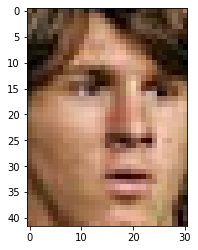

Predicted pins_Lionel Messi with probabilty 74.25%

Top 10 Predicted Classes:
Lionel Messi 74.25%
Tom Cruise 10.53%
Mark Zuckerberg 3.11%
Jake Mcdorman 2.69%
Andy Samberg 1.65%
Jeremy Renner 1.61%
Taylor Swift 0.78%
Maria Pedraza 0.70%
Ben Affleck 0.69%
Tom Holland 0.68%


In [47]:
setup()
model_facenet, model_vector_classifier, face_classes = get_pre_trained()
predict_face(model_facenet, model_vector_classifier, face_classes)  